In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load libraries

In [45]:
!pip install -q transformers 
!pip install -q sentencepiece
import pandas as pd
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification,AutoModel, TFAutoModelForSequenceClassification, AutoConfig,AutoTokenizer
import re
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix
import numpy as np

pd.set_option('display.max_colwidth', None)


#Define pre_trained models & varaibles

In [46]:
MODEL_NAME = 'akhooli/xlm-r-large-arabic-toxic'
BATCH_SIZE = 7
N_EPOCHS = 3

#Load Dataset

In [47]:
df_train = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/train.xlsx')
df_valid = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/dev.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/test.xlsx')
df_test_labels = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/semeval2020/offLabel.xlsx')


#Preprocessing

In [48]:
#Rename Columns
df_train = df_train.rename(columns={'off': 'OFF_Labels','hs': 'HS_Labels'})
df_valid = df_valid.rename(columns={'off': 'OFF_Labels','hs': 'HS_Labels'})
df_test_labels=df_test_labels.rename(columns={'labels':'OFF_Labels'})

In [49]:
# Check missing values
df_train.isnull().sum()

tweets        1
OFF_Labels    0
dtype: int64

In [50]:
#drop any row have null values
df_train=df_train.dropna(how='any',axis=0)
df_valid=df_valid.dropna(how='any',axis=0)
# df_test.dropna()


In [51]:
df_train.isnull().sum()

tweets        0
OFF_Labels    0
dtype: int64

In [52]:
x_train=df_train.tweets
x_valid=df_valid.tweets
x_test=df_test.tweets
y_train=df_train.OFF_Labels
y_valid=df_valid.OFF_Labels
y_test=df_test_labels.OFF_Labels

pd.DataFrame(x_train)[:3]

,tweets
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم يا رجالة ⚪🔴<LF>الدوري يا زمالك .. الدوري يا زمالك<LF>#صدارة_بس
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ان تهلك بني سعود المجرمين. لاجل اطفال اليمن شاركوا.


In [53]:
# x_valid.isnull().sum()

In [54]:
print('Labels on test: ',y_test.unique())
print('Labels on train: ',y_train.unique())

Labels on test:  ['OFF' 'NOT_OFF']
Labels on train:  ['NOT_OFF' 'OFF']


In [55]:
# y_test[:10]


In [56]:
#Check the shape
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape,x_test.shape

((6983,), (6983,), (1000,), (1000,), (2000,))

In [57]:
#Label Encoding to convert labels to integer values
from sklearn.preprocessing import LabelEncoder
print(y_test[:10])
LE = LabelEncoder()
y_train=LE.fit_transform(y_train)
y_valid=LE.fit_transform(y_valid)
y_test=LE.fit_transform(y_test)
y_test[:10]

0        OFF
1        OFF
2    NOT_OFF
3        OFF
4    NOT_OFF
5    NOT_OFF
6    NOT_OFF
7    NOT_OFF
8    NOT_OFF
9    NOT_OFF
Name: OFF_Labels, dtype: object


array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [58]:
# preprocessing function
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>@,\\-_”“٪ًَ]"
def preprocess(text):
  # search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!','#']
  # replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ',' ']
  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", str(text))
  # text = text.replace('وو', 'و')
  # text = text.replace('يي', 'ي')
  # text = text.replace('اا', 'ا')
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  #remove longation
  text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  text = re.sub("[إأآا]", "ا", str(text))
  text = re.sub("ى", "ي", str(text))
  # text = re.sub("ؤ", "ء", text)
  # text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", str(text))
  # for i in range(0, len(search)):
  #       text = text.replace(search[i], replace[i])
  
   #trim    
  # text = text.strip()

  tokens = []
  for token in text.split():
    # if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [59]:
# preprocess('مشكوووور hello 156562سٌلمُ@#')
preprocess('_ salam # @  حمقى 12 ممتازة ياااااااارب ؟ ! سٌلمُ')

'حمقي ممتازه ياارب ؟ ! سلم'

In [60]:
#Apply preproccing on Dataset
x_train = x_train.apply(lambda x: preprocess(x))
x_valid = x_valid.apply(lambda x: preprocess(x))
x_train[:10]

0                                                                            الحمدلله يارب فوز مهم يا زمالك كل الدعم ليكم يا رجاله ⚪🔴 الدوري يا زمالك الدوري يا زمالك صداره بس
1                                                                                                                                      فدوه يا بخت فدوه يا زمن واحد منكم يجيبه
2                                                                                       : يا رب يا واحد يا احد بحق يوم الاحد ان تهلك بني سعود المجرمين لاجل اطفال اليمن شاركوا
3                                                        : هوا الحريه يا وجع قلبي عليكي يا امي الله لا يحرق قلبك ويكسر بخاطرك للمره الف نقف اجلال لعظمه وقدره لين قلب الام ال…
4                                                                                                                                    يا بكون بحياتك الاهم يا اما ما بدي اكون 🎼
5                                                                                                    اخخ يا قلببي يا هالحلقه 

#Prepare data as model input.

In [61]:
x_train = x_train.astype(str)
x_valid = x_valid.astype(str)
x_test = x_test.astype(str)

In [62]:
base_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME,from_pt=True)
# base_model = AutoModel.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


##Tokenizer

In [63]:
#Define a tokenizer object
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#tokenize the text
train_encodings = tokenizer(list(x_train.values),
                            truncation=True, 
                            padding=True)
valid_encodings = tokenizer(list(x_valid.values),
                           truncation=True, 
                           padding=True)
test_encodings = tokenizer(list(x_test.values),
                           truncation=True, 
                           padding=True)

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),list(y_train)))
valid_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encodings),
                                    list(y_valid)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                    list(y_test)))


#Freez layers

In [ ]:
base_model.trainable = False
base_model.summary()
base_model.roberta.count_params

Model: "tfxlm_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  558840832 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  1051650   
Total params: 559,892,482
Trainable params: 0
Non-trainable params: 559,892,482
_________________________________________________________________


<bound method Layer.count_params of <transformers.models.roberta.modeling_tf_roberta.TFRobertaMainLayer object at 0x7f2817369990>>

In [ ]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 1

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

# base_model.summary()


#Fine-tuning with TensorFlow | Build model

In [ ]:
# Define Collbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
    #                                  min_lr = 0.01,
    #                                  monitor = 'val_loss',
    #                                  verbose = 1)
]

In [ ]:

#chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=3e-5)
#define the loss function 
losss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    name='binary_crossentropy')
#build the model
base_model.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])



In [ ]:
# train the model 
history = base_model.fit(train_dataset.shuffle(len(x_train)).batch(BATCH_SIZE),
          validation_data=valid_dataset.shuffle(len(x_valid)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          # epochs=1,
          # callbacks=my_callbacks,
          batch_size=BATCH_SIZE
          )

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

#Confusion matrix

In [ ]:
def predict_proba(text_list, model, tokenizer):  
    #tokenize the text
    encodings = tokenizer(text_list, 
                          max_length=120, 
                          truncation=True, 
                          padding=True)
    #transform to tf.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    #predict
    preds = model.predict(dataset.batch(1)).logits  
    
    #transform to array with probabilities
    # res = tf.nn.sigmoid(preds).numpy()      
    res = tf.nn.softmax(preds, axis=1).numpy()      

    return res

In [ ]:
pred= predict_proba(x_test.to_list(), base_model, tokenizer)

In [ ]:
pred[:30]

array([[0.01689902, 0.983101  ],
       [0.485918  , 0.514082  ],
       [0.7786663 , 0.22133371],
       [0.5091604 , 0.49083957],
       [0.513239  , 0.48676097],
       [0.97451615, 0.02548385],
       [0.9634487 , 0.03655127],
       [0.9006813 , 0.09931866],
       [0.9805967 , 0.01940326],
       [0.9880824 , 0.01191764],
       [0.02192   , 0.97808003],
       [0.6908684 , 0.30913168],
       [0.49896613, 0.50103384],
       [0.5465114 , 0.45348862],
       [0.97343135, 0.02656869],
       [0.9425486 , 0.05745144],
       [0.16079277, 0.83920723],
       [0.841078  , 0.15892202],
       [0.00110498, 0.9988951 ],
       [0.9358979 , 0.06410208],
       [0.33418557, 0.66581446],
       [0.9790046 , 0.02099536],
       [0.9519328 , 0.0480672 ],
       [0.01273546, 0.9872645 ],
       [0.9038381 , 0.09616187],
       [0.5660972 , 0.43390286],
       [0.9103703 , 0.08962973],
       [0.97550255, 0.02449738],
       [0.92272824, 0.07727183],
       [0.8739673 , 0.12603268]], dtype=flo

In [ ]:
pred=np.argmax(pred,axis=1)

In [ ]:
type(y_test)
y_test[:30]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
type(pred)

numpy.ndarray

In [ ]:
print(classification_report(y_test,pred))


              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1598
           1       0.48      0.70      0.57       402

    accuracy                           0.79      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.79      0.80      2000



In [ ]:
print(confusion_matrix(y_test,pred))


[[1297  301]
 [ 120  282]]


In [ ]:
accuracy_score(y_test,pred)

0.7895

#Evaluation model

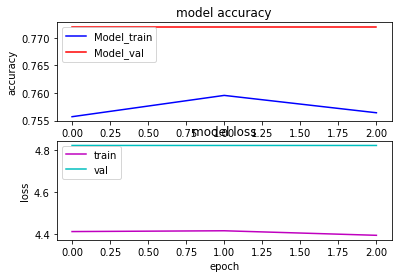

In [ ]:
import matplotlib.pyplot as plt
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Model_train', 'Model_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
# model evaluation on the test set
Loss,Accuracy = base_model.evaluate(test_dataset.shuffle(len(x_test)).batch(BATCH_SIZE), 
               return_dict=True, 
               batch_size=BATCH_SIZE)


286/286 [==============================] - 81s 266ms/step - loss: 5.2710 - accuracy: 0.7890


In [ ]:
# vocab_size = 20000  # Only consider the top 20k words
# maxlen = 200  # Only consider the first 200 words of each movie review

#Unfreez layers

In [93]:
base_model.trainable = True
base_model.summary()

Model: "tfxlm_roberta_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  558840832 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  1051650   
Total params: 559,892,482
Trainable params: 559,892,482
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:1]:
  layer.trainable =  False
base_model.summary()
#build the model


Number of layers in the base model:  2
Model: "tfxlm_roberta_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  558840832 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  1051650   
Total params: 559,892,482
Trainable params: 1,051,650
Non-trainable params: 558,840,832
_________________________________________________________________


#Fine-tuning with TensorFlow | Build model

In [26]:
# Define Collbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
    # tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
    #                                  min_lr = 0.01,
    #                                  monitor = 'val_loss',
    #                                  verbose = 1)
]

In [27]:

#chose the optimizer
optimizerr = tf.keras.optimizers.Adam(learning_rate=3e-5)
#define the loss function 
losss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    name='binary_crossentropy')
#build the model
base_model.compile(optimizer=optimizerr,
              loss=losss,
              metrics=['accuracy'])



In [28]:
# train the model 
history = base_model.fit(train_dataset.shuffle(len(x_train)).batch(BATCH_SIZE),
          validation_data=valid_dataset.shuffle(len(x_valid)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          # epochs=1,
          # callbacks=my_callbacks,
          batch_size=BATCH_SIZE
          )

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

#Evaluation model

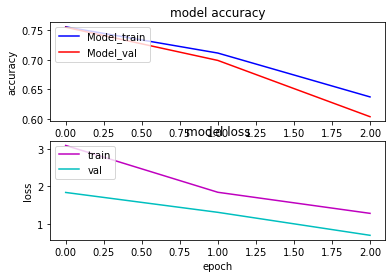

In [29]:
import matplotlib.pyplot as plt
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Model_train', 'Model_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [30]:
# model evaluation on the test set
Loss,Accuracy = base_model.evaluate(test_dataset.shuffle(len(x_test)).batch(BATCH_SIZE), 
               return_dict=True, 
               batch_size=BATCH_SIZE)


286/286 [==============================] - 81s 265ms/step - loss: 0.7685 - accuracy: 0.6145


#Confusion matrix

In [31]:
def predict_proba(text_list, model, tokenizer):  
    #tokenize the text
    encodings = tokenizer(text_list, 
                          max_length=120, 
                          truncation=True, 
                          padding=True)
    #transform to tf.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings)))
    #predict
    preds = model.predict(dataset.batch(1)).logits  
    
    #transform to array with probabilities
    # res = tf.nn.sigmoid(preds).numpy()      
    res = tf.nn.softmax(preds, axis=1).numpy()      

    return res

In [32]:
pred= predict_proba(x_test.to_list(), base_model, tokenizer)

In [33]:
pred[:30]

array([[0.5338375 , 0.4661625 ],
       [0.49024186, 0.5097582 ],
       [0.57478607, 0.42521396],
       [0.5044129 , 0.4955871 ],
       [0.4901942 , 0.5098058 ],
       [0.5581767 , 0.44182327],
       [0.58253187, 0.41746816],
       [0.60443926, 0.39556074],
       [0.55821276, 0.44178724],
       [0.37931636, 0.62068367],
       [0.45866492, 0.5413351 ],
       [0.54028237, 0.45971757],
       [0.4943378 , 0.5056622 ],
       [0.50965923, 0.4903407 ],
       [0.54045826, 0.45954174],
       [0.6202184 , 0.37978163],
       [0.39797023, 0.60202974],
       [0.595543  , 0.404457  ],
       [0.99409497, 0.00590496],
       [0.62677836, 0.37322164],
       [0.44723526, 0.5527648 ],
       [0.53388965, 0.46611035],
       [0.5929824 , 0.40701762],
       [0.6131851 , 0.38681492],
       [0.616521  , 0.38347897],
       [0.51788944, 0.48211056],
       [0.60942084, 0.3905792 ],
       [0.5662144 , 0.43378556],
       [0.636013  , 0.36398703],
       [0.6056394 , 0.39436063]], dtype=flo

In [34]:
pred=np.argmax(pred,axis=1)

In [35]:
# type(y_test)
y_test[:30]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [36]:
print(pred)

[0 1 0 ... 0 0 1]


In [37]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1598
           1       0.25      0.45      0.32       402

    accuracy                           0.61      2000
   macro avg       0.54      0.55      0.52      2000
weighted avg       0.71      0.61      0.65      2000



In [38]:
print(confusion_matrix(y_test,pred))


[[1048  550]
 [ 223  179]]


In [39]:
accuracy_score(y_test,pred)

0.6135